In [1]:
'''started on 06/18/2025'''

'started on 06/18/2025'

In [1]:
'''last updated on 06/23/2025
figure 4'''

'last updated on 06/23/2025\nfigure 4'

In [3]:
'''Images must be provided at final size, preferably 1 column width (8.7cm). Figures wider than 1 column should be sized to 11.4cm or 17.8cm wide. Numbers, letters, and symbols should be no smaller than 6 points (2mm) and no larger than 12 points (6mm) after reduction and must be consistent.'''

'Images must be provided at final size, preferably 1 column width (8.7cm). Figures wider than 1 column should be sized to 11.4cm or 17.8cm wide. Numbers, letters, and symbols should be no smaller than 6 points (2mm) and no larger than 12 points (6mm) after reduction and must be consistent.'

# import

In [1]:
import sys
sys.path.append("/glade/u/home/geethma/phd_research_home/functions")
from imports import *


ERROR 1: PROJ: proj_create_from_database: Open of /glade/u/home/geethma/.conda/envs/wgh/share/proj failed


In [2]:
import tol_colors as tc
from matplotlib.colors import LinearSegmentedColormap
from seaborn import palplot
import pyplot_themes as themes

In [3]:
from my_binned import *
from lat_weight_mean import lat_weight_mean
from load_xarray import *
from TOAf import *
from cyclone_obs import *
from cyclone_metrics import *

In [4]:
# PNAS font sizes
title_fontsize = 8
label_fontsize = 7
tick_fontsize = 6

# figure 2

In [16]:
file = np.load('/glade/campaign/uwyo/wyom0124/variables_filtered/pe.npz')
PE_g_mean = xr.DataArray(file['data'], dims=['runs'], coords={'runs':file['runs']})  # [s-1]

var_list = ['LWPmap_ol', 'pe_maps_ol', 'dLWPmap_gol', 'dSWCREmap', 'dLWCREmap', 'dTSmap_gol']
var_dict = {var: load_xarray(var) for var in var_list}

### Select only common runs for all datasets
var_keys = list(var_dict.keys())
common_members = var_dict[var_keys[0]]["runs"].values
for name in var_keys:
    print(name)
    common_members = np.intersect1d(common_members, var_dict[name]["runs"].values)

var_dict = {name: ds.sel(runs=common_members) for name, ds in var_dict.items()}

totdCRE_g = (var_dict['dLWCREmap']+var_dict['dSWCREmap'])/var_dict['dTSmap_gol']
common_members = np.intersect1d(PE_g_mean['runs'], totdCRE_g['runs'])
totdCRE_g = totdCRE_g.sel(runs=common_members)
PE_g_mean = PE_g_mean.sel(runs=common_members)
dVAR_map_o = [var_dict['dLWPmap_gol'].data/var_dict['dTSmap_gol'].data, totdCRE_g.data]
dVAR_map_o = np.array(dVAR_map_o)
dVar_name = ['∆LWP/∆T', 'λ$_{CRE}$']

grad = [PE_g_mean.data]
grad = np.array(grad)
grad_name = ['P/LWP']

LWPmap_ol
pe_maps_ol
dLWPmap_gol
dSWCREmap
dLWCREmap
dTSmap_gol


<Figure size 449x280 with 0 Axes>

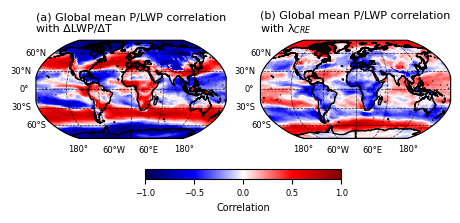

In [18]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import scipy.stats as stats

# Set figure width to 11.4 cm = 4.49 inches for PNAS single-column
fig = plt.figure(figsize=(4.49, 2.8))  # Adjusted height to maintain horizontal layout

lat_sh = var_dict['dLWPmap_gol'].lat.shape[0]
lon_sh = var_dict['dLWPmap_gol'].lon.shape[0]

nums = [[0, 0], [0, 1]]
title_num = ['(a) ', '(b) ']

# PNAS-compliant font sizes
title_fontsize = 8
label_fontsize = 7
tick_fontsize = 6

# Create 1 row, 2 columns
fig, axs = plt.subplots(1, 2, figsize=(4.49, 2.8), subplot_kw={'projection': ccrs.Robinson()}, constrained_layout=True)

for ax_n, ax in enumerate(axs.flat):
    g = nums[ax_n][0]
    d = nums[ax_n][1]

    correlation = np.full((lat_sh, lon_sh), np.nan)
    for i in range(lat_sh):
        for j in range(lon_sh):
            correlation[i, j] = stats.spearmanr(grad[g], dVAR_map_o[d, :, i, j], nan_policy='omit')[0]

    cbar_img = ax.pcolormesh(var_dict['dLWPmap_gol'].lon, var_dict['dLWPmap_gol'].lat, correlation,
                             transform=ccrs.PlateCarree(), cmap='seismic',
                             vmin=-1, vmax=1)

    ax.add_feature(cfeature.LAND, facecolor='white')
    ax.add_feature(cfeature.GSHHSFeature(scale='auto', edgecolor='black'))
    ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
    ax.set_title(title_num[ax_n] + 'Global mean ' + grad_name[g] + ' correlation\nwith ' + dVar_name[d],
                 fontsize=title_fontsize, loc='left')
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='black', alpha=0.8, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'fontsize': 6}  # optional: set label font size
    gl.ylabel_style = {'fontsize': 6}

# Single horizontal colorbar below
cbar = fig.colorbar(cbar_img, ax=axs, orientation='horizontal', fraction=0.05, pad=0.07)
cbar.set_label('Correlation', fontsize=label_fontsize)
cbar.ax.tick_params(labelsize=tick_fontsize)

plt.savefig('final_figures/gPE_LSW∆CRE_∆LWP_correlation.png',
            bbox_inches='tight', facecolor='white', dpi=600)
plt.show()


# Figure S2

LWPmap_ol
pe_maps_ol
dLWPmap_gol
dSWCREmap
dLWCREmap
dTSmap_gol


<Figure size 449x280 with 0 Axes>

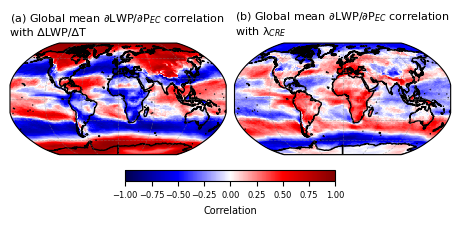

In [4]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import scipy.stats as stats

file = np.load('/glade/campaign/uwyo/wyom0124/variables_filtered/pe.npz')
PE_g_mean = xr.DataArray(file['data'], dims=['runs'], coords={'runs':file['runs']})  # [s-1]

var_list = ['LWPmap_ol', 'pe_maps_ol', 'dLWPmap_gol', 'dSWCREmap', 'dLWCREmap', 'dTSmap_gol']
var_dict = {var: load_xarray(var) for var in var_list}

### Select only common runs for all datasets
var_keys = list(var_dict.keys())
common_members = var_dict[var_keys[0]]["runs"].values
for name in var_keys:
    print(name)
    common_members = np.intersect1d(common_members, var_dict[name]["runs"].values)

var_dict = {name: ds.sel(runs=common_members) for name, ds in var_dict.items()}

totdCRE_g = (var_dict['dLWCREmap']+var_dict['dSWCREmap'])/var_dict['dTSmap_gol']
common_members = np.intersect1d(PE_g_mean['runs'], totdCRE_g['runs'])
totdCRE_g = totdCRE_g.sel(runs=common_members)
PE_g_mean = PE_g_mean.sel(runs=common_members)
dVAR_map_o = [var_dict['dLWPmap_gol'].data/var_dict['dTSmap_gol'].data, totdCRE_g.data]
dVAR_map_o = np.array(dVAR_map_o)
dVar_name = ['∆LWP/∆T', 'λ$_{CRE}$']

grad = [PE_g_mean.data]
grad = np.array(grad)
grad_name = ['P/LWP']

# Set figure width to 11.4 cm = 4.49 inches for PNAS single-column
fig = plt.figure(figsize=(4.49, 2.8))  # Adjusted height to maintain horizontal layout

lat_sh = var_dict['dLWPmap_gol'].lat.shape[0]
lon_sh = var_dict['dLWPmap_gol'].lon.shape[0]

nums = [[0, 0], [0, 1]]
title_num = ['(a) ', '(b) ']

# PNAS-compliant font sizes
title_fontsize = 8
label_fontsize = 7
tick_fontsize = 6

_, PPE_grad_LWP_PRC = cyclone_metrics()
PPE_grad_LWP_PRC = PPE_grad_LWP_PRC.sel(runs=common_members)
grad = [PPE_grad_LWP_PRC.data]
grad = np.array(grad)
grad_name = ['∂LWP/∂P$_{EC}$']

# Create 1 row, 2 columns
fig, axs = plt.subplots(1, 2, figsize=(4.49, 2.8), subplot_kw={'projection': ccrs.Robinson()}, constrained_layout=True)

for ax_n, ax in enumerate(axs.flat):
    g = nums[ax_n][0]
    d = nums[ax_n][1]

    correlation = np.full((lat_sh, lon_sh), np.nan)
    for i in range(lat_sh):
        for j in range(lon_sh):
            correlation[i, j] = stats.spearmanr(grad[g], dVAR_map_o[d, :, i, j], nan_policy='omit')[0]

    cbar_img = ax.pcolormesh(var_dict['dLWPmap_gol'].lon, var_dict['dLWPmap_gol'].lat, correlation,
                             transform=ccrs.PlateCarree(), cmap='seismic',
                             vmin=-1, vmax=1)

    ax.add_feature(cfeature.LAND, facecolor='white')
    ax.add_feature(cfeature.GSHHSFeature(scale='auto', edgecolor='black'))
    ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
    ax.set_title(title_num[ax_n] + 'Global mean ' + grad_name[g] + ' correlation\nwith ' + dVar_name[d],
                 fontsize=title_fontsize, loc='left')

    gl = ax.gridlines(draw_labels=False, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')

# Single horizontal colorbar below
cbar = fig.colorbar(cbar_img, ax=axs, orientation='horizontal', fraction=0.05, pad=0.07)
cbar.set_label('Correlation', fontsize=label_fontsize)
cbar.ax.tick_params(labelsize=tick_fontsize)

plt.savefig('final_figures/∂LWP∂P_LSW∆CRE_∆LWP_correlation.png',
            bbox_inches='tight', facecolor='white', dpi=600)
plt.show()


# figure 3

In [12]:
var_list = ['Pmap_ol_l', 'Pmap_ol_c', 'dLWCREmap', 'dSWCREmap', 'dTSmap_gol', 'LWPmap_ol', 'dLWPmap_gol']
var_dict = {var: load_xarray(var) for var in var_list}

Pmap_ol = var_dict['Pmap_ol_l'] + var_dict['Pmap_ol_c']
PE_g = Pmap_ol/var_dict['LWPmap_ol']
totdCRE_g = (var_dict['dLWCREmap']+var_dict['dSWCREmap'])/var_dict['dTSmap_gol']

_, PPE_grad_LWP_PRC = cyclone_metrics()

common_members = np.intersect1d(PE_g['runs'], totdCRE_g['runs'])
common_members = np.intersect1d(common_members, PPE_grad_LWP_PRC['runs'])
totdCRE_g = totdCRE_g.sel(runs=common_members)
PE_g = PE_g.sel(runs=common_members)
dLWPmap_gol = var_dict['dLWPmap_gol']
dLWPmap_gol = dLWPmap_gol.sel(runs=common_members)
# PPE_grad_LWP_WCB = PPE_grad_LWP_WCB.sel(runs=common_members)
PPE_grad_LWP_PRC = PPE_grad_LWP_PRC.sel(runs=common_members)

PE_g_mean,_,_ = lat_weight_mean(PE_g)

dVAR_map_o = [PE_g_mean.data, PPE_grad_LWP_PRC.data]
dVAR_map_o = np.array(dVAR_map_o)
dVar_name = ['global mean P/LWP', '∂LWP/∂P$_{EC}$']

grad = [PE_g.data]
grad = np.array(grad)
grad_name = ['P/LWP']

In [13]:
from scipy.stats import spearmanr
file = np.load('/glade/campaign/uwyo/wyom0124/variables_filtered/pe.npz')
pe_gm_o = xr.DataArray(file['data'], dims=['runs'], coords={'runs':file['runs']})  # [s-1]
pe_gm_o = pe_gm_o.sel(runs=common_members)
corr, p_value = spearmanr(PPE_grad_LWP_PRC.data*86400, pe_gm_o.data)
print(corr, p_value)

-0.9701408371384408 1.9786941441586365e-156


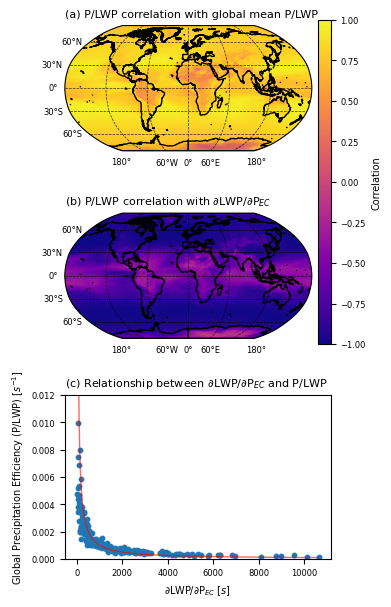

In [16]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import scipy.stats as stats

# Set figure width to 8.7 cm (3.43 inches) — PNAS single-column width
fig = plt.figure(figsize=(3.43, 7))  # Adjust height as needed

# GridSpec: 3 rows, 2 columns (right column reserved for shared colorbar on top row)
gs = gridspec.GridSpec(3, 2, width_ratios=[20, 1], height_ratios=[1, 1, 1.2], hspace=0.35, wspace=0.05)

lat_sh = dLWPmap_gol.lat.shape[0]
lon_sh = dLWPmap_gol.lon.shape[0]
nums = [[0,0], [0,1]]
title_num = ['(a) ', '(b) ']

# --- Top two maps ---
for ax_n in range(2):
    ax = fig.add_subplot(gs[ax_n, 0], projection=ccrs.Robinson())
    g = nums[ax_n][0]
    d = nums[ax_n][1]
    
    correlation = np.full((lat_sh, lon_sh), np.nan)
    for i in range(lat_sh):
        for j in range(lon_sh):
            correlation[i, j] = stats.spearmanr(grad[g, :, i, j], dVAR_map_o[d], nan_policy='omit')[0]

    img = ax.pcolormesh(dLWPmap_gol.lon, dLWPmap_gol.lat, correlation,
                        transform=ccrs.PlateCarree(), cmap='plasma',
                        vmin=-1, vmax=1)
    ax.add_feature(cfeature.LAND, facecolor='white')
    ax.add_feature(cfeature.GSHHSFeature(scale='auto', edgecolor='black'))
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='black', alpha=0.8, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'fontsize': 6}  # optional: set label font size
    gl.ylabel_style = {'fontsize': 6}
    ax.set_title(title_num[ax_n] + grad_name[g] + ' correlation with ' + dVar_name[d],
                 fontsize=title_fontsize, loc='left')

# --- Shared vertical colorbar for the two maps ---
cbar_ax = fig.add_subplot(gs[0:2, 1])  # Span both top rows in the second column
cbar = plt.colorbar(img, cax=cbar_ax, orientation='vertical')
cbar.set_label('Correlation', fontsize=label_fontsize)
cbar.ax.tick_params(labelsize=tick_fontsize)

# --- Scatter plot (bottom row, full width) ---
ax_scatter = fig.add_subplot(gs[2, :])  # Bottom row, span both columns
ax_scatter.scatter(PPE_grad_LWP_PRC.data * 86400, pe_gm_o.data, s=10)
x_values = np.sort(PPE_grad_LWP_PRC.data * 86400)
y_values = 1 / x_values
ax_scatter.plot(x_values, y_values, 'r', alpha=0.6, linewidth=1)

ax_scatter.set_ylim(0, 0.012)
ax_scatter.set_xlabel('∂LWP/∂P$_{EC}$ [$s$]', fontsize=label_fontsize)
ax_scatter.set_ylabel('Global Precipitation Efficiency (P/LWP) [$s^{-1}$]', fontsize=label_fontsize)
ax_scatter.set_title('(c) Relationship between ∂LWP/∂P$_{EC}$ and P/LWP', loc='left', fontsize=title_fontsize)
ax_scatter.tick_params(axis='both', labelsize=tick_fontsize)

# Save figure
plt.savefig('final_figures/PE_correlation.png',
            bbox_inches='tight', dpi=600, facecolor='white')
plt.show()


# figure 4

In [5]:
# GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.mixture import GaussianMixture  
import numpy as np

def emulate_regimes(x_p, y_p1, y_p2, y_p3, c_p):
    # Determine valid (non-NaN) points
    ind = ~np.isnan(x_p * y_p1 * y_p2 * y_p3 * c_p)
    
    # Stack predictors
    input = np.column_stack((
        x_p.data[ind], 
        y_p1.data[ind], 
        y_p2.data[ind], 
        y_p3.data[ind]
    ))
    output = c_p.data[ind]

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        input, output, test_size=0.2, random_state=42
    )

    # Define parameter grid
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [3, 5, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 3, 5],
        'bootstrap': [True, False]
    }

    # Initialize RF Regressor
    rf = RandomForestRegressor(random_state=13)

    # GridSearchCV setup
    grid_search = GridSearchCV(
        estimator=rf,
        param_grid=param_grid,
        cv=3,                  # 3-fold cross-validation
        scoring='r2',          # R² score
        verbose=2,
        n_jobs=-1              # Use all processors
    )

    # Fit GridSearchCV
    grid_search.fit(X_train, y_train)

    # Best model
    best_rf = grid_search.best_estimator_
    print("Best Hyperparameters:", grid_search.best_params_)

    # Predict on training set with best RF
    Ptrain = best_rf.predict(X_train)

    # Metrics
    r2 = r2_score(y_train, Ptrain)
    mse = mean_squared_error(y_train, Ptrain)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_train, Ptrain)
    
    print("Training Performance with Best RF:")
    print("R² Score:", r2)  
    print("MSE:", mse)
    print("RMSE:", rmse)
    print("MAE:", mae)

    # GMM sampling
    n_samples = 1_000_000
    gmm = GaussianMixture(n_components=3, random_state=0)
    gmm.fit(X_train)

    X_new, _ = gmm.sample(n_samples)
    P_new = best_rf.predict(X_new)

    return X_new, P_new


In [6]:
LWP_varn="dLWPmap_gol"; T_varn="dTSmap_gol"; ocean=False
Lv = 2264705.  # J/kg
### Load maps
file_names = {
    "dLWPmap": LWP_varn,
    "dTSmap": T_varn,
    "pe_maps_ol": "pe_maps_ol",
    "pe_maps_o": "pe_maps_o"
}
datasets = {var_name: load_xarray(file_name) for var_name, file_name in file_names.items()}

### ∆LWP map
dLWP_TSmap = datasets['dLWPmap'] / datasets['dTSmap']  # kgm-2K-1
dLWP_TSmap = dLWP_TSmap.assign_coords(lon=(((dLWP_TSmap.lon + 180) % 360) - 180))
dLWP_TSmap = dLWP_TSmap.sortby('lon')

### cloud feedback
cf = (load_xarray('dSWCREmap')+load_xarray('dLWCREmap'))/datasets['dTSmap']
cf = cf.assign_coords(lon=(((cf.lon + 180) % 360) - 180))
cf = cf.sortby('lon')

### PD MC map
PDMC_QFLX_da = datasets['pe_maps_o' if ocean else 'pe_maps_ol']*86400

### converging area
convergence_mask = PDMC_QFLX_da.where(PDMC_QFLX_da > 0, other=np.nan)
# convergence_mask = PDMC_QFLX_da

### incoming solar flux  #downwelling SW flux at TOA
SW_d_list = []
run_numbers = []
for fnum in range(263):
    try:
        fnums = f"{fnum:03d}"
        SWfn_list = np.load(f'/glade/derecho/scratch/geethma/PPE_PD_inSolar/maps_{fnums}.npz')  #PPE_PD_FSDTOA
        SW_maps = np.mean(SWfn_list['data'], axis=0)
        # SW_mean = lat_weight_mean(SW_maps)
        SW_d_list.append(SW_maps)
        run_numbers.append(fnum)
    except FileNotFoundError:
        print(f'{fnums} not available.')
        continue
SW_d_list = np.array(SW_d_list)
SWD_da = xr.DataArray(data=SW_d_list,
                      coords={'runs': run_numbers,
                              'lat': SWfn_list['lat'],
                              'lon': SWfn_list['lon']},
                      dims=['runs','lat','lon'])
SWD_da = SWD_da.assign_coords(lon=(((SWD_da.lon + 180) % 360) - 180))
SWD_da = SWD_da.sortby('lon')  # [Wm-2]
if ocean:
    from get_land_mask import get_land_mask
    land_mask = get_land_mask(SWD_da['lat'], SWD_da['lon'])[0]
    land_mask_da = xr.DataArray(
        land_mask,
        coords={'lat': SWD_da.lat, 'lon': SWD_da.lon},
        dims=['lat', 'lon']
    )
    SWD_da = SWD_da * land_mask_da



In [7]:
### TOA means
TOA = TOAf()
filtered_TOA_15 = TOA.where((TOA >= TOA[0] - 15) & (TOA <= TOA[0] + 15), drop=True)

In [8]:
def sel_regime(xarray, lat_min, lat_max):
    north = xarray.sel(lat=slice(lat_min, lat_max))
    south = xarray.sel(lat=slice(-lat_max, -lat_min))
    xarray_sel = xr.concat([south, north], dim='lat')

    return xarray_sel


In [9]:
## Constrained Pe
from cyclone_obs import *
from cyclone_metrics import *
PPE_grad_LWP_WCB, PPE_grad_LWP_PRC = cyclone_metrics()
obs_dict = cyclone_obs()

In [10]:
# cloudlwp = obs_dict['cloudlwp']*0.001  #[kg/m2]
# wcb = obs_dict['sfcwind']*obs_dict['wvp']*2.66e-7*86400  #[m/s * kg/m2 * m.mm/kg * s/day = mm/day]
# num_bins = 10
# ind = ~np.isnan(wcb * cloudlwp)

# # Calculate bins and statistics in one go
# bin_stats = stats.binned_statistic(wcb[ind], [cloudlwp[ind], wcb[ind]], statistic='mean', bins=num_bins)
# lwp_bin, wcb_bin = bin_stats.statistic
# count = stats.binned_statistic(wcb[ind], wcb[ind], statistic='count', bins=num_bins).statistic
# obs_grad = np.nansum(np.gradient(lwp_bin)/np.gradient(wcb_bin)*count)/np.nansum(count)

# obs_grad_LWP_WCB = obs_grad.copy()

# lower_bound_WCB = obs_grad_LWP_WCB - 0.1 * obs_grad_LWP_WCB
# upper_bound_WCB = obs_grad_LWP_WCB + 0.1 * obs_grad_LWP_WCB

In [11]:
cloudlwp = obs_dict['cloudlwp']*0.001  #[kg/m2]
prc = obs_dict['MWprecipitation']*24  #[mm/day]
num_bins = 10
ind = np.isnan(prc*cloudlwp)==False

### take weighted bins
lwp_bin = stats.binned_statistic(prc[ind], cloudlwp[ind], statistic='mean', bins=num_bins)[0]
prc_bin = stats.binned_statistic(prc[ind], prc[ind], statistic='mean', bins=num_bins)[0]
count   = stats.binned_statistic(prc[ind], prc[ind], statistic='count', bins=num_bins)[0]
obs_grad = np.nansum(np.gradient(lwp_bin)/np.gradient(prc_bin)*count)/np.nansum(count)

print(obs_grad)

obs_grad_LWP_PRC = obs_grad

lower_bound_PRC = obs_grad_LWP_PRC - 0.35 * obs_grad_LWP_PRC
upper_bound_PRC = obs_grad_LWP_PRC + 0.35 * obs_grad_LWP_PRC

0.008106015839806293


In [12]:
pe_metric = PPE_grad_LWP_PRC #PPE_grad_LWP_WCB
obs_pe_metric = obs_grad_LWP_PRC #obs_grad_LWP_WCB
lower_pe_metric, upper_pe_metric = lower_bound_PRC, upper_bound_PRC  #lower_bound_WCB, upper_bound_WCB
xtitle = '$∂LWP/∂P_{EC}$' #'$∂LWP/∂WCB_{EC}$'

In [13]:
#### MERRA2 constraint by area of convergence * SWD
## Moisture convergence
merrafn = xr.open_mfdataset('/glade/derecho/scratch/geethma/merra2/EFLUX/*.nc4', 
                            combine='by_coords', parallel=True)
monthly_merrafn = merrafn.mean(dim='time')
merraMC = (monthly_merrafn['PRECTOT'] - monthly_merrafn['EFLUX']/Lv)*86400
# plt.figure(); merraMC.plot(cmap='seismic')

### TOA SW downwelling
merrafn = xr.open_mfdataset('/glade/derecho/scratch/geethma/merra2/in_solar/*.nc4', 
                            combine='by_coords', parallel=True)  # SW_TOA
monthly_merrafn = merrafn.mean(dim='time')
merraSW = monthly_merrafn['SWTDN']
if ocean:
    from get_land_mask import get_land_mask
    land_mask = get_land_mask(merraMC['lat'], merraMC['lon'])[0]
    merraMC *= land_mask
    merraSW *= land_mask
# plt.figure(); merraSW.plot(cmap='seismic')

# Observational constraint on convergence area
merra_conv_area = merraMC.where(merraMC > 0, other=np.nan)
merra_conv_sw = merra_conv_area*merraSW

In [14]:
# lat_ranges = [(20, 50, 'subtropics'), (50, 90, 'extratropics')]
# # label = ['tropics, extr']

# PPE_prior = []
# RF_prior = []
# RF_posterior = []

# for min_lat, max_lat, regime in lat_ranges:
#     dLWP_TSmap_sel = sel_regime(dLWP_TSmap,min_lat,max_lat)
#     # plt.figure(); dLWP_TSmap_sel[0].plot()
#     convergence_mask_sel = sel_regime(convergence_mask,min_lat,max_lat)
#     SWD_da_sel = sel_regime(SWD_da,min_lat,max_lat)
#     cf_sel = sel_regime(cf,min_lat,max_lat)

#     dLWP_TSmap_sel_mean = lat_weight_mean(dLWP_TSmap_sel)[0]
#     convergence_mask_sel_mean = lat_weight_mean(convergence_mask_sel)[0]
#     SWD_da_sel_mean = lat_weight_mean(SWD_da_sel)[0]
#     cf_mean, cf_sem, cf_std = lat_weight_mean(cf_sel)
#     conv_filter = convergence_mask_sel*SWD_da_sel
#     filter_conv = lat_weight_mean(conv_filter)[0]
    
#     ### Select only common runs for all datasets
#     final_data_n = {
#         "xmap": pe_metric,
#         "ymap1": dLWP_TSmap_sel_mean,
#         "ymap2": convergence_mask_sel_mean,
#         "ymap3": SWD_da_sel_mean,
#         "clrmap": cf_mean,
#         "filter": filtered_TOA_15,
#         "filter2": filter_conv,
#     }
#     keys = list(final_data_n.keys())
#     common_members = final_data_n[keys[0]]["runs"].values
#     for name in keys:
#         # print(name)
#         common_members = np.intersect1d(common_members, final_data_n[name]["runs"].values)
#     final_data = {name: ds.sel(runs=common_members) for name, ds in final_data_n.items()}
    
#     sel_merra_conv_sw = sel_regime(merra_conv_sw, min_lat, max_lat)
#     merraMC_mean, merraMC_sem, _ = lat_weight_mean(sel_merra_conv_sw)
#     # print(merraMC_mean.values)
#     # obs_constraint_lower = merraMC_mean.values - merraMC_sem.values
#     # obs_constraint_upper = merraMC_mean.values + merraMC_sem.values
#     from scipy.stats import norm
#     z_95 = norm.ppf(0.975)  # ~1.96
#     obs_constraint_lower = merraMC_mean.values - z_95 * merraMC_sem.values
#     obs_constraint_upper = merraMC_mean.values + z_95 * merraMC_sem.values
    
#     # Identify constrained points
#     PPE_conv_SWD = final_data['filter2']
#     constrained = (PPE_conv_SWD.values >= obs_constraint_lower) & (PPE_conv_SWD.values <= obs_constraint_upper)
    
#     x_p = final_data['xmap']
#     y_p1 = final_data['ymap1']
#     y_p2 = final_data['ymap2']
#     y_p3 = final_data['ymap3']
#     y_p = y_p1*y_p2*y_p3
#     c_p = final_data['clrmap']
#     X_new, P_new = emulate_regimes(x_p, y_p1, y_p2, y_p3, c_p)

#     plt.figure()
#     plt.scatter(X_new[:,0], X_new[:,1]*X_new[:,2]*X_new[:,3], c=P_new, cmap='seismic',
#                vmin=-0.6, vmax=0.6)
#     plt.colorbar(label='RF $λ_{CRE}$')
#     plt.scatter(x_p, y_p, c=c_p, cmap='spring', marker='s', s=72,
#                vmin=-0.6, vmax=0.6)
#     plt.colorbar(label='PPE $λ_{CRE}$')
#     plt.scatter(x_p.sel(runs=constrained), y_p.sel(runs=constrained), 
#                 edgecolor='black', facecolor='none', marker='s', s=100, linewidth=1.5, label='Obs Constrained')
#     plt.axvline(x=obs_pe_metric, color='grey', linestyle='--')
#     plt.axvspan(lower_pe_metric, upper_pe_metric, facecolor='grey', alpha=0.3)
#     plt.xlabel(xtitle)
#     plt.ylabel('∆LWP_conv * A_conv * Incoming Solar flux')
#     # plt.savefig('figures/∆LWP_Aconv_solarVS∂LWP∂WCBVSCF.png', bbox_inches='tight', dpi=500, facecolor='white')
#     plt.title(regime)
#     plt.show()


#     # constrained ∆CRE
#     pe_constrained = (X_new[:,0] >= lower_pe_metric) & (X_new[:,0] <= upper_pe_metric)
#     conv_constrained = (X_new[:,2]*X_new[:,3] >= obs_constraint_lower) & (X_new[:,2]*X_new[:,3] <= obs_constraint_upper)
#     both_constrained = pe_constrained & conv_constrained
#     P_new_constrained = P_new[both_constrained]

#     # # Full RF (prior)
#     # plt.figure()
#     # plt.hist(c_p, bins=30, alpha=0.5, label='PPE Prior', color='red', density=True)
#     # plt.hist(P_new, bins=30, alpha=0.5, label='RF Prior', color='grey', density=True)
    
#     # # RF posterior (those satisfying all constraints)
#     # if len(P_new_constrained)>0:
#     #     plt.hist(P_new_constrained, bins=30, alpha=0.7, label='RF Posterior', color='teal', density=True)
#     # plt.axvline(x=c_p[0], color='black', linestyle='-.', label='CAM6 default value')
    
#     # plt.xlabel('ΔCRE')
#     # plt.ylabel('Probability Density')
#     # plt.legend()
#     # plt.title(regime)
#     # plt.show()

#     PPE_prior.append(c_p)
#     RF_prior.append(P_new)
#     RF_posterior.append(P_new_constrained)


In [15]:
default, default_sem, _ = lat_weight_mean(sel_regime(cf,20,90))

In [16]:
# def plot_pdfs(data, bin_c):
#     conf = 2.5
#     a = data
#     a_min = np.percentile(a,conf)
#     a_med = np.percentile(a,50)
#     a_max = np.percentile(a,100.-conf)
#     # print('the original range is: ',a_min,a_max)
#     print('95th percentile taken')
#     a = np.array(a)
#     a_95 = a[(a >= a_min) & (a <= a_max)]

#     hist, bins = np.histogram(a_95, bins=bin_c, density=True)
#     bin_centers = (bins[1:]+bins[:-1])*0.5

#     return bin_centers, hist

In [17]:
# prior_means = [np.nanmean(i) for i in RF_prior]
# prior_stds  = [np.nanstd(i)  for i in RF_prior]
# post_means  = [np.nanmean(i) for i in RF_posterior]
# post_stds   = [np.nanstd(i)  for i in RF_posterior]

# # Latitude bands: only subtropics and extratropics
# lat_bounds = [(20, 50), (50, 90)]
# weights = [np.sin(np.radians(max_lat)) - np.sin(np.radians(min_lat)) for min_lat, max_lat in lat_bounds]
# weights = np.array(weights) / np.sum(weights)  # Normalize weights to sum to 1

# n_samples_global = 100000

# # Sampling prior
# prior_samples = []
# for i in range(len(prior_means)):
#     samples = np.random.normal(prior_means[i], prior_stds[i], int(weights[i] * n_samples_global))
#     prior_samples.append(samples)
# global_prior_samples = np.concatenate(prior_samples)

# # Sampling posterior
# post_samples = []
# for i in range(len(prior_means)):
#     samples = np.random.normal(post_means[i], post_stds[i], int(weights[i] * n_samples_global))
#     post_samples.append(samples)
# global_post_samples = np.concatenate(post_samples)

# # Plot
# plt.axvline(default[0], color='black', linestyle='-.', label='CAM6 default value')
# plt.axvspan(default[0]-1.96*default_sem[0], default[0]+1.96*default_sem[0], facecolor='black', alpha=0.3)
# # plt.axvline(0.19, color='red', linestyle='-.', label='Myers (2021)')
# plt.hist(global_prior_samples, bins=50, density=True, alpha=0.5, label='Prior', color='b')
# plt.hist(global_post_samples, bins=50, density=True, alpha=0.5, label='Posterior ('+xtitle+')', color='orange')
# bin_centers, hist = plot_pdfs(global_prior_samples, 50)
# plt.plot(bin_centers, hist, label='95% prior', color='b')
# bin_centers, hist = plot_pdfs(global_post_samples, 50)
# plt.plot(bin_centers, hist, label='95% posterior', color='orange')
# plt.legend()
# plt.xlabel('$\lambda_{CRE}$')
# plt.ylabel('Density')
# plt.title('Area-weighted Global Prior and Posterior (Subtropics + Extratropics)')
# plt.show()


In [18]:
# prior_means = [np.nanmean(i) for i in RF_prior]
# prior_stds  = [np.nanstd(i)  for i in RF_prior]
# post_means  = [np.nanmean(i) for i in RF_posterior]
# post_stds   = [np.nanstd(i)  for i in RF_posterior]

# # Latitude bands: only subtropics and extratropics
# lat_bounds = [(20, 50), (50, 90)]
# weights = [np.sin(np.radians(max_lat)) - np.sin(np.radians(min_lat)) for min_lat, max_lat in lat_bounds]
# weights = np.array(weights) / np.sum(weights)  # Normalize weights to sum to 1

# n_samples_global = 100000

# # Sampling prior
# prior_samples = []
# for i in range(len(prior_means)):
#     samples = np.random.normal(prior_means[i], prior_stds[i], int(weights[i] * n_samples_global))
#     prior_samples.append(samples)
# global_prior_samples = np.concatenate(prior_samples)

# # Sampling posterior
# post_samples = []
# for i in range(len(prior_means)):
#     samples = np.random.normal(post_means[i], post_stds[i], int(weights[i] * n_samples_global))
#     post_samples.append(samples)
# global_post_samples = np.concatenate(post_samples)

# # Plot
# plt.axvline(default[0], color='black', linestyle='-.', label='CAM6 default value')
# plt.axvspan(default[0]-1.96*default_sem[0], default[0]+1.96*default_sem[0], facecolor='black', alpha=0.3)
# # plt.axvline(0.19, color='red', linestyle='-.', label='Myers (2021)')
# plt.hist(global_prior_samples, bins=50, density=True, alpha=0.5, label='Prior', color='b')
# plt.hist(global_post_samples, bins=50, density=True, alpha=0.5, label='Posterior ('+xtitle+')', color='orange')
# bin_centers, hist = plot_pdfs(global_prior_samples, 50)
# plt.plot(bin_centers, hist, label='95% prior', color='b')
# bin_centers, hist = plot_pdfs(global_post_samples, 50)
# plt.plot(bin_centers, hist, label='95% posterior', color='orange')
# plt.legend()
# plt.xlabel('$\lambda_{CRE}$')
# plt.ylabel('Density')
# plt.title('Area-weighted Global Prior and Posterior (Subtropics + Extratropics)')
# plt.show()


In [19]:
def plot_pdfs_diff(data, bin_c):
    conf = 2.5
    a = data
    a_min = np.percentile(a,conf)
    a_med = np.percentile(a,50)
    a_max = np.percentile(a,100.-conf)
    # print('the original range is: ',a_min,a_max)
    print('95th percentile taken')
    a = np.array(a)
    a_95 = a[(a >= a_min) & (a <= a_max)]

    hist, bins = np.histogram(a_95, bins=bin_c, density=True)
    bin_centers = (bins[1:]+bins[:-1])*0.5

    return bin_centers, hist*np.diff(bins)

In [20]:
# prior_means = [np.nanmean(i) for i in RF_prior]
# prior_stds  = [np.nanstd(i)  for i in RF_prior]
# post_means  = [np.nanmean(i) for i in RF_posterior]
# post_stds   = [np.nanstd(i)  for i in RF_posterior]

# # Latitude bands: only subtropics and extratropics
# lat_bounds = [(20, 50), (50, 90)]
# weights = [np.sin(np.radians(max_lat)) - np.sin(np.radians(min_lat)) for min_lat, max_lat in lat_bounds]
# weights = np.array(weights) / np.sum(weights)  # Normalize weights to sum to 1

# n_samples_global = 100000

# # Sampling prior
# prior_samples = []
# for i in range(len(prior_means)):
#     samples = np.random.normal(prior_means[i], prior_stds[i], int(weights[i] * n_samples_global))
#     prior_samples.append(samples)
# global_prior_samples = np.concatenate(prior_samples)

# # Sampling posterior
# post_samples = []
# for i in range(len(prior_means)):
#     samples = np.random.normal(post_means[i], post_stds[i], int(weights[i] * n_samples_global))
#     post_samples.append(samples)
# global_post_samples = np.concatenate(post_samples)

# # Plot
# plt.axvline(default[0], color='black', linestyle='-.', label='CAM6 default value')
# plt.axvspan(default[0]-1.96*default_sem[0], default[0]+1.96*default_sem[0], facecolor='black', alpha=0.3)
# # plt.axvline(0.19, color='red', linestyle='-.', label='Myers (2021)')
# # plt.hist(global_prior_samples, bins=50, density=True, alpha=0.5, label='Prior', color='b')
# # plt.hist(global_post_samples, bins=50, density=True, alpha=0.5, label='Posterior ('+xtitle+')', color='orange')
# bin_centers, hist = plot_pdfs_diff(global_prior_samples, 50)
# plt.plot(bin_centers, hist, label='95% prior', color='b')
# bin_centers, hist = plot_pdfs_diff(global_post_samples, 50)
# plt.plot(bin_centers, hist, label='95% posterior ('+xtitle+')', color='orange')
# plt.legend()
# plt.xlabel('$\lambda_{CRE}$')
# plt.ylabel('Density')
# plt.title('Area-weighted Global Prior and Posterior (Subtropics + Extratropics)')
# plt.show()


In [21]:
# prior_means = [np.nanmean(i) for i in RF_prior]
# prior_stds  = [np.nanstd(i)  for i in RF_prior]
# post_means  = [np.nanmean(i) for i in RF_posterior]
# post_stds   = [np.nanstd(i)  for i in RF_posterior]

# # Latitude bands: only subtropics and extratropics
# lat_bounds = [(20, 50), (50, 90)]
# weights = [np.sin(np.radians(max_lat)) - np.sin(np.radians(min_lat)) for min_lat, max_lat in lat_bounds]
# weights = np.array(weights) / np.sum(weights)  # Normalize weights to sum to 1

# n_samples_global = 100000

# # Sampling prior
# prior_samples = []
# for i in range(len(prior_means)):
#     samples = np.random.normal(prior_means[i], prior_stds[i], int(weights[i] * n_samples_global))
#     prior_samples.append(samples)
# global_prior_samples = np.concatenate(prior_samples)

# # Sampling posterior
# post_samples = []
# for i in range(len(prior_means)):
#     samples = np.random.normal(post_means[i], post_stds[i], int(weights[i] * n_samples_global))
#     post_samples.append(samples)
# global_post_samples = np.concatenate(post_samples)

# # Plot
# plt.axvline(default[0], color='black', linestyle='-.', label='CAM6 default value')
# plt.axvspan(default[0]-1.96*default_sem[0], default[0]+1.96*default_sem[0], facecolor='black', alpha=0.3)
# # plt.axvline(0.19, color='red', linestyle='-.', label='Myers (2021)')
# # plt.hist(global_prior_samples, bins=50, density=True, alpha=0.5, label='Prior', color='b')
# # plt.hist(global_post_samples, bins=50, density=True, alpha=0.5, label='Posterior ('+xtitle+')', color='orange')
# bin_centers, hist = plot_pdfs_diff(global_prior_samples, 50)
# plt.plot(bin_centers, hist, label='95% prior', color='b')
# bin_centers, hist = plot_pdfs_diff(global_post_samples, 50)
# plt.plot(bin_centers, hist, label='95% posterior ('+xtitle+')', color='orange')
# plt.legend()
# plt.xlabel('$\lambda_{CRE}$')
# plt.ylabel('Density')
# plt.title('Area-weighted Global Prior and Posterior (Subtropics + Extratropics)')
# plt.show()


In [40]:
# fig, axs = plt.subplots(3, 1, figsize=(17.8/2.54, 12))  # 17.8 cm width converted to inches
# title_num = ['(a) ', '(b) ', '(c) ']


# lat_ranges = [(20, 50, 'subtropics'), (50, 90, 'extratropics')]

# PPE_prior = []
# RF_prior = []
# RF_posterior = []

# # create dummy lists to store the scatter handles for colorbars
# sc1_list = []
# sc2_list = []

# for idx, (min_lat, max_lat, regime) in enumerate(lat_ranges):
#     # your data selection part stays the same...
#     dLWP_TSmap_sel = sel_regime(dLWP_TSmap,min_lat,max_lat)
#     convergence_mask_sel = sel_regime(convergence_mask,min_lat,max_lat)
#     SWD_da_sel = sel_regime(SWD_da,min_lat,max_lat)
#     cf_sel = sel_regime(cf,min_lat,max_lat)

#     dLWP_TSmap_sel_mean = lat_weight_mean(dLWP_TSmap_sel)[0]
#     convergence_mask_sel_mean = lat_weight_mean(convergence_mask_sel)[0]
#     SWD_da_sel_mean = lat_weight_mean(SWD_da_sel)[0]
#     cf_mean, cf_sem, cf_std = lat_weight_mean(cf_sel)
#     conv_filter = convergence_mask_sel*SWD_da_sel
#     filter_conv = lat_weight_mean(conv_filter)[0]

#     final_data_n = {
#         "xmap": pe_metric,
#         "ymap1": dLWP_TSmap_sel_mean,
#         "ymap2": convergence_mask_sel_mean,
#         "ymap3": SWD_da_sel_mean,
#         "clrmap": cf_mean,
#         "filter": filtered_TOA_15,
#         "filter2": filter_conv,
#     }
#     keys = list(final_data_n.keys())
#     common_members = final_data_n[keys[0]]['runs'].values
#     for name in keys:
#         common_members = np.intersect1d(common_members, final_data_n[name]['runs'].values)
#     final_data = {name: ds.sel(runs=common_members) for name, ds in final_data_n.items()}

#     sel_merra_conv_sw = sel_regime(merra_conv_sw, min_lat, max_lat)
#     merraMC_mean, merraMC_sem, _ = lat_weight_mean(sel_merra_conv_sw)
#     from scipy.stats import norm
#     z_95 = norm.ppf(0.975)
#     obs_constraint_lower = merraMC_mean.values - z_95 * merraMC_sem.values
#     obs_constraint_upper = merraMC_mean.values + z_95 * merraMC_sem.values

#     PPE_conv_SWD = final_data['filter2']
#     constrained = (PPE_conv_SWD.values >= obs_constraint_lower) & (PPE_conv_SWD.values <= obs_constraint_upper)

#     x_p = final_data['xmap']
#     y_p1 = final_data['ymap1']
#     y_p2 = final_data['ymap2']
#     y_p3 = final_data['ymap3']
#     y_p = y_p1*y_p2*y_p3
#     c_p = final_data['clrmap']
#     X_new, P_new = emulate_regimes(x_p, y_p1, y_p2, y_p3, c_p)

#     # Emulation and scatter plots
#     sc1 = axs[idx].scatter(X_new[:,0], X_new[:,1]*X_new[:,2]*X_new[:,3], c=P_new, cmap='seismic', vmin=-0.6, vmax=0.6)
#     sc2 = axs[idx].scatter(x_p, y_p, c=c_p, cmap='spring', marker='s', s=72, vmin=-0.6, vmax=0.6)
#     axs[idx].scatter(x_p.sel(runs=constrained), y_p.sel(runs=constrained), edgecolor='black', facecolor='none', marker='s', s=100, linewidth=1.5)
#     axs[idx].axvline(x=obs_pe_metric, color='grey', linestyle='--')
#     axs[idx].axvspan(lower_pe_metric, upper_pe_metric, facecolor='grey', alpha=0.3)
#     axs[idx].set_xlabel(xtitle, fontsize=label_fontsize)
#     axs[idx].set_ylabel('∆LWP_conv * A_conv * Incoming Solar flux', fontsize=label_fontsize)
#     axs[idx].set_title(title_num[idx]+regime, fontsize=title_fontsize)

#     sc1_list.append(sc1)
#     sc2_list.append(sc2)

#     # same: constraint, posterior, etc.
#     pe_constrained = (X_new[:,0] >= lower_pe_metric) & (X_new[:,0] <= upper_pe_metric)
#     conv_constrained = (X_new[:,2]*X_new[:,3] >= obs_constraint_lower) & (X_new[:,2]*X_new[:,3] <= obs_constraint_upper)
#     both_constrained = pe_constrained & conv_constrained
#     P_new_constrained = P_new[both_constrained]

#     PPE_prior.append(c_p)
#     RF_prior.append(P_new)
#     RF_posterior.append(P_new_constrained)

# # Add shared colorbars for subplot 0 and 1
# from mpl_toolkits.axes_grid1 import make_axes_locatable

# # First colorbar (for 'seismic')
# divider = make_axes_locatable(axs[1])
# cax1 = divider.append_axes("right", size="3%", pad=0.1)
# cbar1 = fig.colorbar(sc1_list[0], cax=cax1)
# cbar1.set_label('RF $λ_{CRE}$')

# # Second colorbar (for 'spring')
# divider2 = make_axes_locatable(axs[1])
# cax2 = divider2.append_axes("right", size="3%", pad=1.0)  # adjust pad to avoid overlap
# cbar2 = fig.colorbar(sc2_list[0], cax=cax2)
# cbar2.set_label('PPE $λ_{CRE}$')

# # Your posterior plot (axs[2]) remains the same...
# prior_means = []
# prior_stds  = []
# post_means  = []
# post_stds   = []
# prior_means = [np.nanmean(i) for i in RF_prior]
# prior_stds  = [np.nanstd(i)  for i in RF_prior]
# post_means  = [np.nanmean(i) for i in RF_posterior]
# post_stds   = [np.nanstd(i)  for i in RF_posterior]

# lat_bounds = [(20, 50), (50, 90)]
# weights = [np.sin(np.radians(max_lat)) - np.sin(np.radians(min_lat)) for min_lat, max_lat in lat_bounds]
# weights = np.array(weights) / np.sum(weights)

# n_samples_global = 100000

# prior_samples = []
# for i in range(len(prior_means)):
#     samples = np.random.normal(prior_means[i], prior_stds[i], int(weights[i] * n_samples_global))
#     prior_samples.append(samples)
# global_prior_samples = np.concatenate(prior_samples)

# post_samples = []
# for i in range(len(prior_means)):
#     samples = np.random.normal(post_means[i], post_stds[i], int(weights[i] * n_samples_global))
#     post_samples.append(samples)
# global_post_samples = np.concatenate(post_samples)

# axs[2].axvline(default[0], color='black', linestyle='-.', label='CAM6 default value')
# axs[2].axvspan(default[0]-1.96*default_sem[0], default[0]+1.96*default_sem[0], facecolor='black', alpha=0.3)
# bin_centers, hist = plot_pdfs_diff(global_prior_samples, 50)
# axs[2].plot(bin_centers, hist, label='95% prior', color='b')
# bin_centers, hist = plot_pdfs_diff(global_post_samples, 50)
# axs[2].plot(bin_centers, hist, label='95% posterior ('+xtitle+')', color='orange')
# axs[2].legend(fontsize=label_fontsize)
# axs[2].set_xlabel('$\\lambda_{CRE}$', fontsize=label_fontsize)
# axs[2].set_ylabel('Density', fontsize=label_fontsize)
# axs[2].set_title(title_num[2]+'Area-weighted Global Prior and Posterior (Subtropics + Extratropics)', fontsize=label_fontsize)

# plt.tight_layout()
# plt.savefig('final_figures/constraint.png',
#             bbox_inches='tight', facecolor='white', dpi=600)
# plt.show()


/glade/derecho/scratch/geethma/tmp/ipykernel_115157/2427105984.py:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.95, 1]) # Adjust layout to prevent colorbar overlap


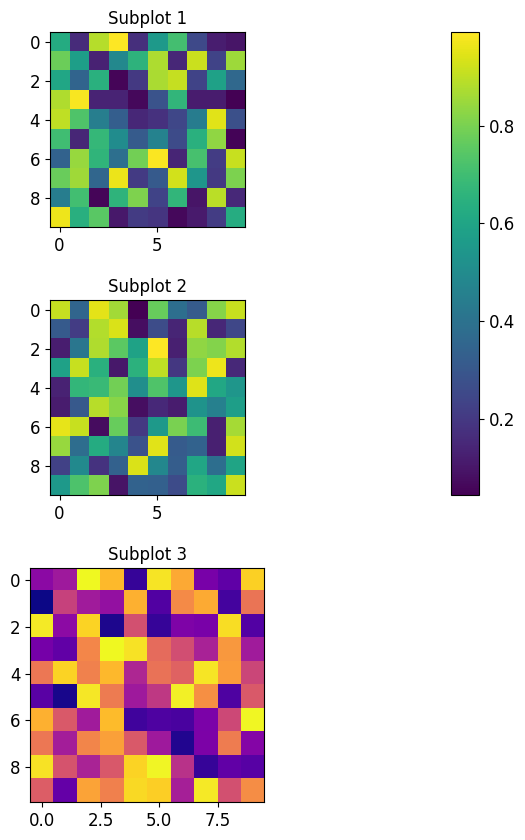

In [42]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec

# Create some sample data
data1 = np.random.rand(10, 10)
data2 = np.random.rand(10, 10)
data3 = np.random.rand(10, 10)

fig = plt.figure(figsize=(8, 10))
gs = gridspec.GridSpec(3, 2, width_ratios=[20, 1], height_ratios=[1, 1, 1.2], hspace=0.35, wspace=0.05)

# Create the main axes
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[2, 0])

# Create the colorbar axis
cbar_ax = fig.add_subplot(gs[0:2, 1]) # Spans first two rows of the second column

# Plot on the first two subplots (using the same norm and cmap for shared colorbar)
im1 = ax1.imshow(data1, cmap='viridis')
im2 = ax2.imshow(data2, cmap='viridis')

# Create the shared colorbar
plt.colorbar(im1, cax=cbar_ax)

# Plot on the third subplot
ax3.imshow(data3, cmap='plasma')

ax1.set_title('Subplot 1')
ax2.set_title('Subplot 2')
ax3.set_title('Subplot 3')

plt.tight_layout(rect=[0, 0, 0.95, 1]) # Adjust layout to prevent colorbar overlap
plt.show()


Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END bootstrap=True, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END bootstrap=True, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END bootstrap=True, max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END 

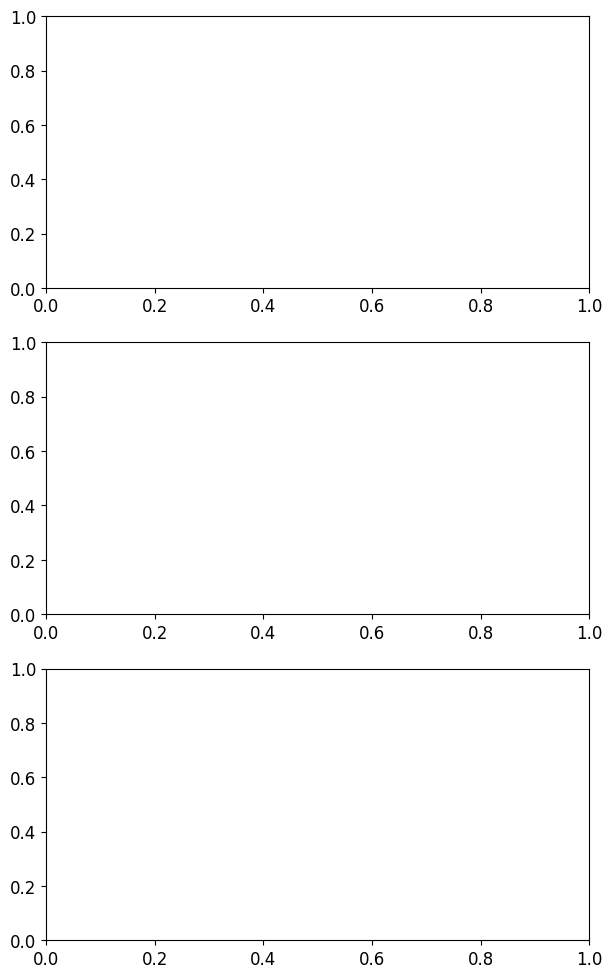

In [43]:
fig, axs = plt.subplots(3, 1, figsize=(17.8/2.54, 12))  # 17.8 cm width converted to inches
title_num = ['(a) ', '(b) ', '(c) ']

lat_ranges = [(20, 50, 'subtropics'), (50, 90, 'extratropics')]

PPE_prior = []
RF_prior = []
RF_posterior = []

for idx, (min_lat, max_lat, regime) in enumerate(lat_ranges):
    dLWP_TSmap_sel = sel_regime(dLWP_TSmap,min_lat,max_lat)
    convergence_mask_sel = sel_regime(convergence_mask,min_lat,max_lat)
    SWD_da_sel = sel_regime(SWD_da,min_lat,max_lat)
    cf_sel = sel_regime(cf,min_lat,max_lat)

    dLWP_TSmap_sel_mean = lat_weight_mean(dLWP_TSmap_sel)[0]
    convergence_mask_sel_mean = lat_weight_mean(convergence_mask_sel)[0]
    SWD_da_sel_mean = lat_weight_mean(SWD_da_sel)[0]
    cf_mean, cf_sem, cf_std = lat_weight_mean(cf_sel)
    conv_filter = convergence_mask_sel*SWD_da_sel
    filter_conv = lat_weight_mean(conv_filter)[0]

    final_data_n = {
        "xmap": pe_metric,
        "ymap1": dLWP_TSmap_sel_mean,
        "ymap2": convergence_mask_sel_mean,
        "ymap3": SWD_da_sel_mean,
        "clrmap": cf_mean,
        "filter": filtered_TOA_15,
        "filter2": filter_conv,
    }
    keys = list(final_data_n.keys())
    common_members = final_data_n[keys[0]]['runs'].values
    for name in keys:
        common_members = np.intersect1d(common_members, final_data_n[name]['runs'].values)
    final_data = {name: ds.sel(runs=common_members) for name, ds in final_data_n.items()}

    sel_merra_conv_sw = sel_regime(merra_conv_sw, min_lat, max_lat)
    merraMC_mean, merraMC_sem, _ = lat_weight_mean(sel_merra_conv_sw)
    from scipy.stats import norm
    z_95 = norm.ppf(0.975)
    obs_constraint_lower = merraMC_mean.values - z_95 * merraMC_sem.values
    obs_constraint_upper = merraMC_mean.values + z_95 * merraMC_sem.values

    PPE_conv_SWD = final_data['filter2']
    constrained = (PPE_conv_SWD.values >= obs_constraint_lower) & (PPE_conv_SWD.values <= obs_constraint_upper)

    x_p = final_data['xmap']
    y_p1 = final_data['ymap1']
    y_p2 = final_data['ymap2']
    y_p3 = final_data['ymap3']
    y_p = y_p1*y_p2*y_p3
    c_p = final_data['clrmap']
    X_new, P_new = emulate_regimes(x_p, y_p1, y_p2, y_p3, c_p)

    # cbar_img = axs[idx].scatter(X_new[:,0], X_new[:,1]*X_new[:,2]*X_new[:,3], c=P_new, cmap='seismic', vmin=-0.6, vmax=0.6)
    # axs[idx].scatter(x_p, y_p, c=c_p, cmap='spring', marker='s', s=72, vmin=-0.6, vmax=0.6)
    # axs[idx].scatter(x_p.sel(runs=constrained), y_p.sel(runs=constrained), edgecolor='black', facecolor='none', marker='s', s=100, linewidth=1.5)
    # axs[idx].axvline(x=obs_pe_metric, color='grey', linestyle='--')
    # axs[idx].axvspan(lower_pe_metric, upper_pe_metric, facecolor='grey', alpha=0.3)
    # axs[idx].set_xlabel(xtitle, fontsize=label_fontsize)
    # axs[idx].set_ylabel('∆LWP_conv * A_conv * Incoming Solar flux', fontsize=label_fontsize)
    # axs[idx].set_title(title_num[idx]+regime, fontsize=title_fontsize)

    pe_constrained = (X_new[:,0] >= lower_pe_metric) & (X_new[:,0] <= upper_pe_metric)
    conv_constrained = (X_new[:,2]*X_new[:,3] >= obs_constraint_lower) & (X_new[:,2]*X_new[:,3] <= obs_constraint_upper)
    both_constrained = pe_constrained & conv_constrained
    P_new_constrained = P_new[both_constrained]

    PPE_prior.append([x_p, y_p, c_p])
    RF_prior.append([X_new[:,0], X_new[:,1]*X_new[:,2]*X_new[:,3], P_new])
    RF_posterior.append(P_new_constrained)

# Single horizontal colorbar below
# cbar = fig.colorbar(cbar_img, ax=axs, orientation='vertical', fraction=0.05, pad=0.07)
# cbar.set_label('Correlation', fontsize=label_fontsize)
# cbar.ax.tick_params(labelsize=tick_fontsize)

# plt.tight_layout()

prior_means = [np.nanmean(i) for i in RF_prior]
prior_stds  = [np.nanstd(i)  for i in RF_prior]
post_means  = [np.nanmean(i) for i in RF_posterior]
post_stds   = [np.nanstd(i)  for i in RF_posterior]

lat_bounds = [(20, 50), (50, 90)]
weights = [np.sin(np.radians(max_lat)) - np.sin(np.radians(min_lat)) for min_lat, max_lat in lat_bounds]
weights = np.array(weights) / np.sum(weights)

n_samples_global = 100000

prior_samples = []
for i in range(len(prior_means)):
    samples = np.random.normal(prior_means[i], prior_stds[i], int(weights[i] * n_samples_global))
    prior_samples.append(samples)
global_prior_samples = np.concatenate(prior_samples)

post_samples = []
for i in range(len(prior_means)):
    samples = np.random.normal(post_means[i], post_stds[i], int(weights[i] * n_samples_global))
    post_samples.append(samples)
global_post_samples = np.concatenate(post_samples)

# axs[2].axvline(default[0], color='black', linestyle='-.', label='CAM6 default value')
# axs[2].axvspan(default[0]-1.96*default_sem[0], default[0]+1.96*default_sem[0], facecolor='black', alpha=0.3)
# bin_centers, hist = plot_pdfs_diff(global_prior_samples, 50)
# axs[2].plot(bin_centers, hist, label='95% prior', color='b')
# bin_centers, hist = plot_pdfs_diff(global_post_samples, 50)
# axs[2].plot(bin_centers, hist, label='95% posterior ('+xtitle+')', color='orange')
# axs[2].legend()
# axs[2].set_xlabel('$\\lambda_{CRE}$', fontsize=label_fontsize)
# axs[2].set_ylabel('Density', fontsize=label_fontsize)
# axs[2].set_title(title_num[2]+'Area-weighted Global Prior and Posterior (Subtropics + Extratropics)', fontsize=label_fontsize)

# plt.tight_layout()
# plt.savefig('final_figures/constraint.png',
#             bbox_inches='tight', facecolor='white', dpi=600)
# plt.show()


95th percentile taken
95th percentile taken


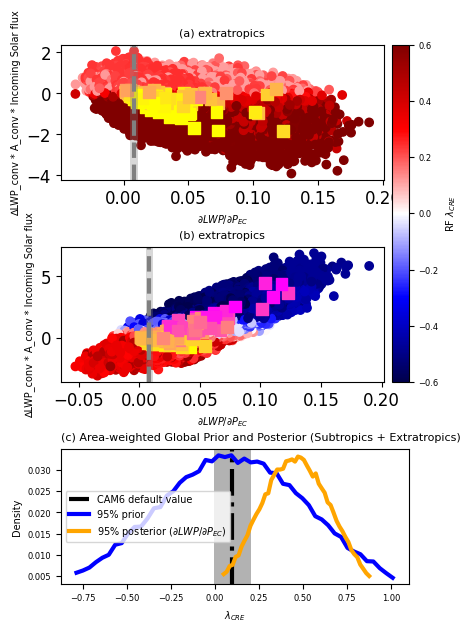

In [49]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import scipy.stats as stats

# Set figure width to 8.7 cm (3.43 inches) — PNAS single-column width
fig = plt.figure(figsize=(11.4/2.54, 7))  # Adjust height as needed
# fig, axs = plt.subplots(3, 1, figsize=(11.4/2.54, 12))  # 17.8 cm width converted to inches

# GridSpec: 3 rows, 2 columns (right column reserved for shared colorbar on top row)
gs = gridspec.GridSpec(3, 2, width_ratios=[20, 1], height_ratios=[1, 1, 1], hspace=0.5, wspace=0.05)

# lat_sh = dLWPmap_gol.lat.shape[0]
# lon_sh = dLWPmap_gol.lon.shape[0]
nums = [[0,0], [0,1]]
# title_num = ['(a) ', '(b) ']

# --- Top two maps ---
for ax_n in range(2):
    ax = fig.add_subplot(gs[ax_n, 0])
    g = nums[ax_n][0]
    d = nums[ax_n][1]

    # cbar_img = axs[idx].scatter(X_new[:,0], X_new[:,1]*X_new[:,2]*X_new[:,3], c=P_new, cmap='seismic', vmin=-0.6, vmax=0.6)
    # axs[idx].scatter(x_p, y_p, c=c_p, cmap='spring', marker='s', s=72, vmin=-0.6, vmax=0.6)
    # axs[idx].scatter(x_p.sel(runs=constrained), y_p.sel(runs=constrained), edgecolor='black', facecolor='none', marker='s', s=100, linewidth=1.5)
    # axs[idx].axvline(x=obs_pe_metric, color='grey', linestyle='--')
    # axs[idx].axvspan(lower_pe_metric, upper_pe_metric, facecolor='grey', alpha=0.3)
    # axs[idx].set_xlabel(xtitle, fontsize=label_fontsize)
    # axs[idx].set_ylabel('∆LWP_conv * A_conv * Incoming Solar flux', fontsize=label_fontsize)
    # axs[idx].set_title(title_num[idx]+regime, fontsize=title_fontsize)

    temp = RF_prior[ax_n]
    img = ax.scatter(temp[0], temp[1], c=temp[2], 
                     cmap='seismic', vmin=-0.6, vmax=0.6)
    p_temp = PPE_prior[ax_n]
    p_img = ax.scatter(p_temp[0], p_temp[1], c=p_temp[2], 
                        cmap='spring', marker='s', s=72, vmin=-0.6, vmax=0.6)
    # axs.scatter(x_p.sel(runs=constrained), y_p.sel(runs=constrained), edgecolor='black', facecolor='none', marker='s', s=100, linewidth=1.5)
    ax.axvline(x=obs_pe_metric, color='grey', linestyle='--')
    ax.axvspan(lower_pe_metric, upper_pe_metric, facecolor='grey', alpha=0.3)
    ax.set_xlabel(xtitle, fontsize=label_fontsize)
    ax.set_ylabel('∆LWP_conv * A_conv * Incoming Solar flux', fontsize=label_fontsize)
    ax.set_title(title_num[ax_n]+regime, fontsize=title_fontsize)


# --- Shared vertical colorbar for the two maps ---
cbar_ax = fig.add_subplot(gs[0:2, 1])  # Span both top rows in the second column
cbar = plt.colorbar(img, cax=cbar_ax, orientation='vertical')
cbar.set_label('RF $\\lambda_{CRE}$', fontsize=label_fontsize)
cbar.ax.tick_params(labelsize=tick_fontsize)

# --- Scatter plot (bottom row, full width) ---
ax_scatter = fig.add_subplot(gs[2, :])  # Bottom row, span both columns
ax_scatter.axvline(default[0], color='black', linestyle='-.', label='CAM6 default value')
ax_scatter.axvspan(default[0]-1.96*default_sem[0], default[0]+1.96*default_sem[0], facecolor='black', alpha=0.3)
bin_centers, hist = plot_pdfs_diff(global_prior_samples, 50)
ax_scatter.plot(bin_centers, hist, label='95% prior', color='b')
bin_centers, hist = plot_pdfs_diff(global_post_samples, 50)
ax_scatter.plot(bin_centers, hist, label='95% posterior ('+xtitle+')', color='orange')
ax_scatter.legend(fontsize=label_fontsize)

ax_scatter.set_xlabel('$\\lambda_{CRE}$', fontsize=label_fontsize)
ax_scatter.set_ylabel('Density', fontsize=label_fontsize)
ax_scatter.set_title(title_num[2]+'Area-weighted Global Prior and Posterior (Subtropics + Extratropics)', 
                     loc='left', fontsize=title_fontsize)
ax_scatter.tick_params(axis='both', labelsize=tick_fontsize)

# axs[2].axvline(default[0], color='black', linestyle='-.', label='CAM6 default value')
# axs[2].axvspan(default[0]-1.96*default_sem[0], default[0]+1.96*default_sem[0], facecolor='black', alpha=0.3)
# bin_centers, hist = plot_pdfs_diff(global_prior_samples, 50)
# axs[2].plot(bin_centers, hist, label='95% prior', color='b')
# bin_centers, hist = plot_pdfs_diff(global_post_samples, 50)
# axs[2].plot(bin_centers, hist, label='95% posterior ('+xtitle+')', color='orange')
# axs[2].legend()
# axs[2].set_xlabel('$\\lambda_{CRE}$', fontsize=label_fontsize)
# axs[2].set_ylabel('Density', fontsize=label_fontsize)
# axs[2].set_title(title_num[2]+'Area-weighted Global Prior and Posterior (Subtropics + Extratropics)', fontsize=label_fontsize)

# plt.tight_layout()
plt.savefig('final_figures/constraint.png',
            bbox_inches='tight', facecolor='white', dpi=600)
plt.show()
